# Gravitational settling



## eEMEP

non-spherical, F=0.8=(d1+d2)/(2*d3)

In [264]:
import numpy as np

def potential_temperature(tempC, presPa):
    return (tempC+273.15)*(100000/presPa)**0.286

def monodisperse_terminal_v(diameter,
                            density_p, # kg/m3
                            pot_temp,
                            pressure_mid):

    """
    Calculate monodisperese terminal fall velocity volcanic ash using equations
    as used in Steensen (2017) paper from Zannetti (1990) + cunnigham slip factor + drag
    coefficient for near spherical particles (F=0.8)
    https://gmd.copernicus.org/articles/10/1927/2017/gmd-10-1927-2017.pdf section 2.2.4

    inputs: diameter in [m]
            density_p [kg/m3]
            pot_temp in [K];   array of mid-point pot. temperatures
            pressure_mid [Pa]; array of mid-point pressure levels

    """

    r_specific = 287.050
    kappa = 0.286
    F = 1 # 0.8
    g = 9.81

    temp_abs = pot_temp * np.exp(kappa*np.log(pressure_mid*1e-5))
    density_a = pressure_mid / r_specific / temp_abs

    temperature = temp_abs - 273.15 # here in celsius
    zvis = np.empty(np.shape(temperature))

    for index, item in enumerate(temperature): # temperature here in deg. Celsius
        if item >= 0:
            zvis[index] = (1.718 + 0.0049*item)*1e-5 # [Pa s]
        else:
            zvis[index] = (1.718 + 0.0049*item - 1.2e-05*(item**2))*1e-5 # [Pa s]

    # temperature here in Kelvin
    # mean free path of air (Prupp. Klett) in [m], [T] in Kelvin. Eq. 10. 140 2nd edition
    zair = 6.6e-8 * (1013.25 / (pressure_mid * 1e-2)) * (temp_abs / 293.15) # [m]


# combine equations for terminal fall velocity (v), drag coefficient (C_d), and Reynolds number (Re) into
#  a single quadratic expression in v. Equations from doi:10.5194/gmd-10-1927-2017
#
#  v**2 = (4 * g * ( density_p - density_a) * d ) / (3 * C_d * density_a)
#  C_d = (24 / Re) * F**-0.828 + 2 * SQRT(1.07 - F)
#  Re = v * density_a * d / zvis
#
#  Combing the above three expressions yields
#
# [6 * density_a * SQRT(1.07 - F)] * v**2 + [72 * zvis * F**-0.828 / d] * v + [-4 * g * (density_p - density_a) * d] = 0

    quad_a = 6 * density_a * np.sqrt(1.07 - F)
    quad_b = 72 * zvis / diameter * F ** -0.828
    quad_c = -4 * g * (density_p - density_a) * diameter

    zdum = (-quad_b + np.sqrt(quad_b**2 - 4 * quad_a * quad_c)) / (2 * quad_a)

    knut = 2 * zair / diameter
    v_t = zdum * (1 + 1.257 * knut + 0.4 * np.exp(-1.1 / knut)) # m/s

    print(f"temperature = {temperature}")
    print(f"Re = {v_t * density_a * diameter / zvis}")

    return v_t


temperature = [ 15.  -56.5 -56.5]
Re = [5.56218727e-06 3.66470328e-06 1.95522243e-06]
diam.: 1, v_t: [0.00029284 0.00050856 0.0011216 ]
temperature = [ 15.  -56.5 -56.5]
Re = [0.00485937 0.00244474 0.00068849]
diam.: 10, v_t: [0.02558343 0.03392643 0.03949469]
temperature = [ 15.  -56.5 -56.5]
Re = [0.03853462 0.01904221 0.0049944 ]
diam.: 20, v_t: [0.10143784 0.13212722 0.14325093]
temperature = [ 15.  -56.5 -56.5]
Re = [0.59198478 0.2910375  0.07316028]
diam.: 50, v_t: [0.62333198 0.80776275 0.83936149]
temperature = [ 15.  -56.5 -56.5]
Re = [4.3694378  2.22208346 0.56654038]
diam.: 100, v_t: [2.30040571 3.08365119 3.24993415]
temperature = [ 15.  -56.5 -56.5]
Re = [24.76989748 14.17436011  4.15958294]
diam.: 200, v_t: [ 6.52038275  9.83509019 11.93063293]


[Text(0.5, 0, 'fall velocity [km/h]'), Text(0, 0.5, 'height [m]')]

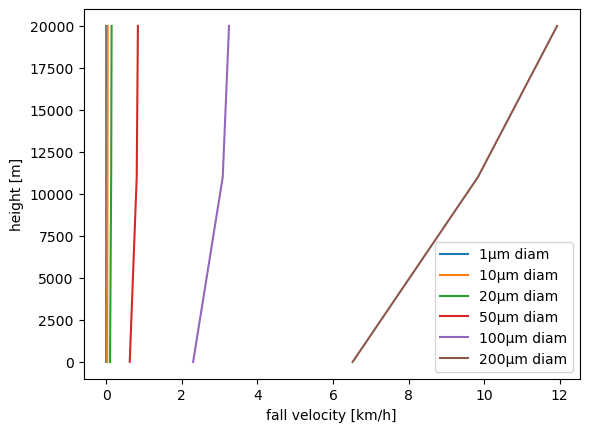

In [265]:
from matplotlib import pyplot as plt

std_atmosphere = {
    "height": np.array([0., 11000., 20000.]),
    "pressure": np.array([101325., 22632., 5475.]),
    "temperature": np.array([15., -56.5, -56.5]),
}
pot_temp = potential_temperature(presPa=std_atmosphere["pressure"], tempC=std_atmosphere["temperature"])

fig, ax = plt.subplots()
for psize in [1, 10, 20, 50, 100, 200]:
    fall_velocities = monodisperse_terminal_v(psize*1e-6,
                                            2300,
                                            pot_temp,
                                            std_atmosphere["pressure"])
    ax.plot(fall_velocities*3.6, std_atmosphere["height"],label=f"{psize}µm diam")
    print(f"diam.: {psize}, v_t: {fall_velocities*3.6}")
ax.legend()
ax.set(xlabel='fall velocity [km/h]', ylabel="height [m]")


## SNAP vgrav

Zannetti (1990) and RAF (1999)

In [266]:

def cun(dp):
    """cunningham factor (Zannetti (1990))
    c = 1 + (2*l/dp)*(a1+a2*exp(-a3*dp/l))

    :param dp: particle size in µm
    """
    a1=1.257
    a2=0.40
    a3=0.55
    l=0.0653
    cun=1.0+(2.0*l/dp)*(a1+a2*np.exp(-a3*dp/l))
    return cun

def visc(temperature):
    """viscoity

    viscosity according to RAFF (1999), Kyle (1991) in poise = g/(cm*s)
    :param temperatur: absolute temp [K]
    """
    return 1.72e-4*(393.0/(temperature+120.0))*(temperature/273.0)**1.5

def rho_air(pressure, temperature):
    """rho air g/cm³

    air density, RAF (1999)
    :param pressure: pressure [hPa]
    :param temperature: aboslute temp [K]
    """
    return 0.001*pressure*100/(287.4 * temperature)

def fit(u,dp,rp,p,t):
    """cunningham slip correction, fit function to iteratively finding correct vgrav from
    Pandis.

    :param u: vg during iteration
    :param dp: diameter µm
    :param rp: density g/cm3
    :param p: pressure hPa
    :param t: abs temp K
    """
    a1 = 0.15
    a2 = 0.687

    u0=vgrav(dp,rp,p,t)
    etha=visc(t)
    re=u*dp*1.0e-4*rho_air(p,t)/etha
    x = u*(1.0+a1*re**a2) - u0
    if(u == 0.0):
        x = -u0
    return x

def iter_vgrav(dp,rp,p,t):
    """iterative procedure to fit vgrav

    :param dp: diameter of particle µm
    :param rp: rho/density particle g/cm3
    :param p: pressure [hPa]
    :param t: absolute temperature [K]

    :return: computed vg

    """
    u0 = vgrav(dp,rp,p,t)
    eps=0.001*u0 # accuracy
    it = 0
    x1 = 0
    x2 = u0
    y1=fit(x1,dp,rp,p,t)
    while it < 100:
        it=it+1
        x=0.5*(x2+x1)
        y=fit(x,dp,rp,p,t)
        if(abs(y) < eps):
            return x
        if (y1*y < 0.0):
            x2 = x
        else:
            x1 = x
            y1=fit(x1,dp,rp,p,t)

    raise RuntimeError(f"cannot find vgrav after {it} iterations: {x,y}")

def vgrav(dp, rp, pressure, temperature):
    """snap vgrav function

    :param dp: particle size [µm]
    :param rp: density [g/cm3]
    :param pressure: [hPa]
    :param temperature: absolute temp [K]
    """
    g = 981 # cm/s
    return (dp*0.0001)**2 * g*(rp-rho_air(pressure,temperature))*cun(dp) / (18.0*visc(temperature))


def grav_snap(diameter, density_p, temperature, pressure):
    """
    inputs: diameter in [m]
            density_p [kg/m3]
            temperature in [C]; temperatures
            pressure_mid [Pa]; pressure
    outputs: speed in [m/s]
    """
    outvec = np.asarray(pressure)
    for i in range(len(pressure)):
        px = pressure[i]/100
        tx = temperature[i]+273.15
        outvec[i] = iter_vgrav(diameter*1e6, density_p/1000, px, tx)*0.01
    return outvec

def gravitational_settling(roa, diam, ro_part):
    """new code implemented for new dry-depositions (surface)

    :param roa: air densitiy [kg/m3]
    :param diam: diameter in [m]
    :param ro_part: particle density [kg/m3]
    :return: velocity in [m/s]
    """
    # mean free path in air [m]
    lam = 0.065e-6
    # gravity [m/s]
    grav = 9.8
    # Kinematic viscosity of air, m2 s-1 at +15 C
    ny = 1.5e-5

    my = ny * roa
    fac1 = -0.55 * diam / lam
    cslip = 1 + 2 * lam / diam * ( 1.257 + 0.4 * np.exp(fac1) )

    vs = ro_part * diam * diam * grav * cslip / (18*my)
    return vs

size: 1, vt=[0.00029208 0.00036967 0.00036972]
size: 10, vt=[0.02551462 0.03228031 0.03228031]
size: 20, vt=[0.10123427 0.12807852 0.12807852]
size: 50, vt=[0.62962351 0.79658047 0.79658047]
size: 100, vt=[2.51437312 3.18110818 3.18110818]
size: 200, vt=[10.04925059 12.70157716 12.70157716]


[Text(0.5, 0, 'fall velocity [km/h]'), Text(0, 0.5, 'height [m]')]

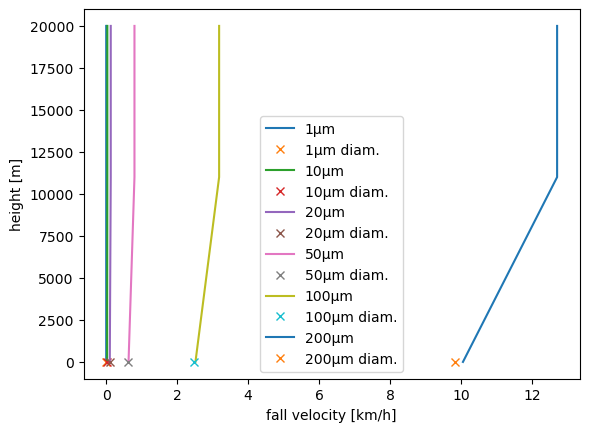

In [267]:

fig, ax = plt.subplots()
for psize in [1, 10, 20, 50, 100, 200]:
    fall_velocities = grav_snap(psize*1e-6,
                                2300,
                                std_atmosphere["temperature"],
                                std_atmosphere["pressure"])
    ax.plot(fall_velocities*3.6, std_atmosphere["height"],label=f"{psize}µm")
    print(f"size: {psize}, vt={fall_velocities*3.6}")
    ax.plot(gravitational_settling(rho_air(1013.25, 15+273.15) * 1000, psize*1e-6, 2300)*3.6, 0, 'x', label=f"{psize}µm diam.")

ax.legend()
ax.set(xlabel='fall velocity [km/h]', ylabel="height [m]")



## Dynamic viscosity

### eEMEP
after https://pub.deadnet.se/Books_and_manuals_on_various_stuff/Geology/Microphysics%20of%20Clouds%20and%20Precipitation%202nd%20ed%20-%20H.%20Pruppacher%2C%20J.%20Klett%20%28Kluwer%2C%201997%29%20WW.pdf eq. 10-141a/b

In [268]:
def visc_eemep(t):
    """dynamic viscosity in poise after Pruppacher-Klett
    Microphysics of Clounds and Precipitaiton, eq. 10-141a/b

    :param t: temperature [°C]
    :return: viscosity in [Pa s = 10 poise]
    """

    if t >= 0:
        vis = (1.718 + 0.0049*t)*1e-5 # [Pa s]
    else:
        vis = (1.718 + 0.0049*t - 1.2e-05*(t**2))*1e-5 # [Pa s]

    return vis


### SNAP



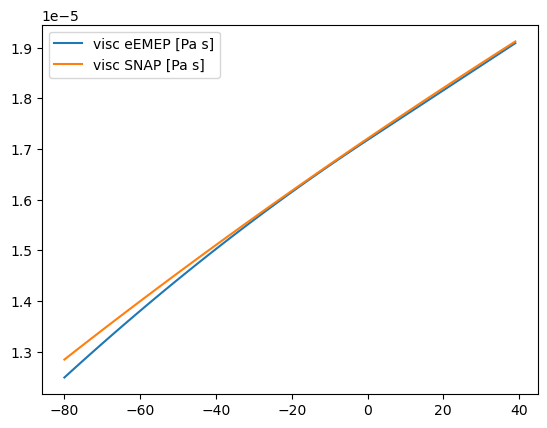

In [269]:
def visc_snap(t):
    t_K = t+273.15
    visc = 1.72e-4*(393.0/(t_K+120.0))*(t_K/273.0)**1.5 # poise
    return visc/10 # Pa s

temps = np.arange(-80,40,1)
ny_eemep = [visc_eemep(t) for t in temps]
plt.plot(temps, ny_eemep, label="visc eEMEP [Pa s]")
temps = np.arange(-80,40,1)
ny = [visc_snap(t) for t in temps]
plt.plot(temps, ny, label="visc SNAP [Pa s]")
plt.legend()
